# Load Dependency


In [ ]:
!nvidia-smi

Sat Dec 12 10:15:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install scikit-tensor-py3

     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 17.4MB 357kB/s 
     |████████████████████████████████| 25.2MB 1.3MB/s 
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.16.6 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.3.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [5]:
from google.colab import drive
import pandas as pd
import numpy as np
import random
import os
# from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.externals import joblib
#
# from keras.models import Sequential,Model
# from keras.layers import Dense,Input,Embedding,Concatenate,Reshape,Flatten
# from keras.layers import LSTM,Dropout,Activation,Bidirectional
# from keras.optimizers import Adagrad, Adam, SGD, RMSprop
# from keras.models import load_model,save_model
# from keras.utils import plot_model
#
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, LSTM,Dropout,Activation,Input,Bidirectional
from tensorflow.keras.optimizers import Adagrad, Adam, SGD, RMSprop
from tensorflow.keras.models import load_model,save_model
from tensorflow.keras.utils import plot_model,to_categorical
# import tensorflow as tf
# from tensorflow import keras
# drive.mount('/content/gdrive/') 

# Load Data

In [8]:
!gdown --id 1-RXYMh61x9asaVU_w5tDHtq0CMmp_Rdn
!gdown --id 1--znLUhuYqoMMqQo1Gnf6WafrzzniIFL

Downloading...
From: https://drive.google.com/uc?id=1-RXYMh61x9asaVU_w5tDHtq0CMmp_Rdn
To: /content/TrainData.csv
2.58GB [00:15, 165MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--znLUhuYqoMMqQo1Gnf6WafrzzniIFL
To: /content/TestData.csv
645MB [00:07, 88.1MB/s]


In [9]:
%%time
# Load Raw Data
# https://drive.google.com/file/d/1-RXYMh61x9asaVU_w5tDHtq0CMmp_Rdn/view?usp=sharing
file_path_train = './TrainData.csv'
# https://drive.google.com/file/d/1--znLUhuYqoMMqQo1Gnf6WafrzzniIFL/view?usp=sharing
file_path_test ='./TestData.csv'
cols = ['id','userId', 'gender', 'sport', 'calories', 'Route_id','derived_distance','altitude','derived_speed','heart_rate','distance','time_elapsed']
train_df = pd.read_csv(file_path_train,usecols=cols)
test_df = pd.read_csv(file_path_test,usecols=cols)
train_df.rename(columns={'derived_speed': 'speed'},inplace=True)

test_df.rename(columns={'derived_speed': 'speed'},inplace=True)
print(train_df.shape)
print(test_df.shape)

(50253, 12)
(12578, 12)
CPU times: user 15.9 s, sys: 2.14 s, total: 18.1 s
Wall time: 18.6 s


In [10]:
train_df.groupby(['Route_id','sport']).size()

Route_id  sport        
0         bike              4722
1         bike              2756
2         bike             10666
3         bike               788
4         bike               259
5         mountain bike      549
6         mountain bike      131
7         mountain bike     1941
8         run               3271
9         run               3353
10        run              17465
11        run                819
12        run               3089
13        run                444
dtype: int64

In [11]:
train_df.head(3)

,id,userId,gender,sport,calories,distance,altitude,heart_rate,derived_distance,speed,time_elapsed,Route_id
0,611012078,2568526,male,run,830.588,10.02,"[137.8, 137.8, 138.2, 138.8, 138.8, 138.6, 139...","[140, 140, 141, 149, 149, 150, 153, 157, 160, ...","[0.0016049429213742246, 0.01260242289257531, 0...","[5.777794516947209, 10.005378447215753, 10.428...","[1, 4, 5, 1, 5, 6, 11, 4, 6, 7, 8, 7, 7, 9, 5,...",9
1,326004692,11889307,unknown,bike,530.000,46.04,"[18.4, 17.6, 17.6, 17.6, 19.0, 19.8, 21.4, 22....","[80, 75, 68, 71, 78, 71, 67, 66, 64, 75, 68, 6...","[0.04356151376031798, 0.11363834298901357, 0.0...","[26.136908256190786, 34.09150289670407, 39.197...","[6, 12, 7, 11, 8, 10, 11, 8, 9, 13, 6, 13, 11,...",0
2,282989006,1912029,female,run,848.631,10.89,"[498.8, 498.4, 497.4, 495.2, 493.4, 491.0, 490...","[82, 93, 104, 117, 128, 135, 137, 139, 138, 14...","[0.010829722470982562, 0.010618715062935378, 0...","[7.797400179107444, 8.821489242357188, 8.31756...","[5, 4, 7, 8, 11, 7, 19, 6, 13, 13, 13, 11, 11,...",8


In [12]:
# Encode gender feature

conditions = [
    (train_df['gender'] == 'male'),
    (train_df['gender'] == 'female'),
    (train_df['gender'] == 'unknown')]

choices = [0, 1, 2]

train_df['genderId'] = np.select(conditions, choices, default=0)

conditions = [
    (test_df['gender'] == 'male'),
    (test_df['gender'] == 'female'),
    (test_df['gender'] == 'unknown')]

test_df['genderId'] = np.select(conditions, choices, default=0)

In [13]:
# Encode sport feature

conditions = [
    (train_df['sport'] == 'run'),
    (train_df['sport'] == 'bike'),
    (train_df['sport'] == 'mountain bike')]

choices = [0, 1, 2]

train_df['sportId'] = np.select(conditions, choices, default=0)

conditions = [
    (test_df['sport'] == 'run'),
    (test_df['sport'] == 'bike'),
    (test_df['sport'] == 'mountain bike')]

test_df['sportId'] = np.select(conditions, choices, default=0)

In [17]:
!wget https://drive.google.com/drive/folders/13GpKEaFOSyv0QvWLPoD053QyF43YyIZu?usp=sharing

--2020-12-12 10:28:22--  https://drive.google.com/drive/folders/13GpKEaFOSyv0QvWLPoD053QyF43YyIZu?usp=sharing
Resolving drive.google.com (drive.google.com)... 108.177.127.138, 108.177.127.100, 108.177.127.113, ...
Connecting to drive.google.com (drive.google.com)|108.177.127.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘13GpKEaFOSyv0QvWLPoD053QyF43YyIZu?usp=sharing’

13GpKEaFOSyv0QvWLPo     [  <=>               ] 197.23K   710KB/s    in 0.3s    

2020-12-12 10:28:23 (710 KB/s) - ‘13GpKEaFOSyv0QvWLPoD053QyF43YyIZu?usp=sharing’ saved [201959]



In [26]:
from google.colab import files
files.upload()
# upload CS31-2-USYD/Pre-trained Model/scaler model/scaler.zip
!unzip -uq './scaler.zip' -d './scaler'

Saving scaler.zip to scaler (1).zip


In [27]:
# Load Min-max scaler models
scaler_dic = dict()
features = ['calories', 'distance', 'heart_rate', 'altitude', 'derived_distance', 'speed']

dir = './scaler'
for feature in features:
    path = os.path.join(dir, 'scaler_'+feature+'_2.m')
    scaler_dic[feature] = joblib.load(path)

scaler_dic

{'altitude': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'calories': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'derived_distance': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'distance': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'heart_rate': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'speed': MinMaxScaler(copy=True, feature_range=(0, 1))}

In [28]:
train_sequence_df = train_df[['altitude', 'heart_rate',
                       'derived_distance', 'speed']].copy()
train_context_df = train_df[['id','userId', 'genderId', 'sportId', 'calories', 'distance', 'Route_id']].copy()

test_sequence_df = test_df[['altitude', 'heart_rate',
                       'derived_distance', 'speed']].copy()
test_context_df = test_df[['id','userId', 'genderId', 'sportId', 'calories', 'distance', 'Route_id']].copy()

display(train_sequence_df.head(1))
display(train_context_df.head(1))

,altitude,heart_rate,derived_distance,speed
0,"[137.8, 137.8, 138.2, 138.8, 138.8, 138.6, 139...","[140, 140, 141, 149, 149, 150, 153, 157, 160, ...","[0.0016049429213742246, 0.01260242289257531, 0...","[5.777794516947209, 10.005378447215753, 10.428..."


,id,userId,genderId,sportId,calories,distance,Route_id
0,611012078,2568526,0,0,830.588,10.02,9


In [29]:
# Apply min max scaler for each feature
%%time
# for features in sequence_df
for feature in train_sequence_df.columns:
    # Reshape data using array.reshape(-1, 1) if data has a single feature
    train_sequence_df[feature] = train_sequence_df.apply(lambda x: np.concatenate(
        scaler_dic[feature].transform(np.array(eval(x[feature])).reshape(-1, 1)), axis=0)[0:499], axis=1)
    
    test_sequence_df[feature] = test_sequence_df.apply(lambda x: np.concatenate(
        scaler_dic[feature].transform(np.array(eval(x[feature])).reshape(-1, 1)), axis=0)[0:499], axis=1)


# for features in context_df
for feature in train_context_df[train_context_df.columns.difference(['id','userId',
              'genderId', 
              'sportId', 
              'Route_id'])].columns:
    # Reshape data using array.reshape(-1, 1) if data has a single feature
    train_context_df[feature] = scaler_dic[feature].transform(
        train_context_df[feature].to_numpy().reshape(-1, 1))
    
    test_context_df[feature] = scaler_dic[feature].transform(
        test_context_df[feature].to_numpy().reshape(-1, 1))


display(train_sequence_df.head(1))
display(train_context_df.head(1))

,altitude,heart_rate,derived_distance,speed
0,"[0.21051532033426185, 0.21051532033426185, 0.2...","[0.5833333333333334, 0.5833333333333334, 0.587...","[0.0008705472935918672, 0.006835760322515244, ...","[0.05777888189652973, 0.10005540659781222, 0.1..."


,id,userId,genderId,sportId,calories,distance,Route_id
0,611012078,2568526,0,0,0.149145,0.07643,9


CPU times: user 4min 9s, sys: 5.29 s, total: 4min 14s
Wall time: 4min 14s


In [30]:
train_df = pd.concat([train_context_df, train_sequence_df], axis=1)
test_df = pd.concat([test_context_df, test_sequence_df], axis=1)

train_df.head(1)

,id,userId,genderId,sportId,calories,distance,Route_id,altitude,heart_rate,derived_distance,speed
0,611012078,2568526,0,0,0.149145,0.07643,9,"[0.21051532033426185, 0.21051532033426185, 0.2...","[0.5833333333333334, 0.5833333333333334, 0.587...","[0.0008705472935918672, 0.006835760322515244, ...","[0.05777888189652973, 0.10005540659781222, 0.1..."


### Load embedding layer

In [31]:
!gdown --id 1ILtqnNBaCfEsV7mrJ4UGPMp9fK3iHiq7
!gdown --id 1Z9XqkkfHG-HOdwSrLTf2k-9-IMB3xor5

Downloading...
From: https://drive.google.com/uc?id=1ILtqnNBaCfEsV7mrJ4UGPMp9fK3iHiq7
To: /content/userEmbed_tensorD_13.m
100% 443k/443k [00:00<00:00, 69.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Z9XqkkfHG-HOdwSrLTf2k-9-IMB3xor5
To: /content/routeEmbed_tensorD_13.m
100% 8.18k/8.18k [00:00<00:00, 7.07MB/s]


In [32]:
# load embedding layer r = 13

routeEmbed_file_path = './routeEmbed_tensorD_13.m'
userEmbed_file_path = './userEmbed_tensorD_13.m'
# # load embedding layer r = 11
# routeEmbed_file_path = '/content/gdrive/My Drive/endomondoHR/Data/embedding/routeEmbed_tensorD_11.m'
# userEmbed_file_path = '/content/gdrive/My Drive/endomondoHR/Data/embedding/userEmbed_tensorD_11.m'
# # load embedding layer r = 2
# routeEmbed_file_path = '/content/gdrive/My Drive/endomondoHR/Data/embedding/routeEmbed_tensorD_2.m'
# userEmbed_file_path = '/content/gdrive/My Drive/endomondoHR/Data/embedding/userEmbed_tensorD_2.m'

route_embed_df=joblib.load(routeEmbed_file_path)
user_embed_df=joblib.load(userEmbed_file_path)
route_embed_dict = {row['Route_id']:list(row['routeEmbed']) for index,row in route_embed_df.iterrows()}
user_embed_dict = {row['userId']:list(row['userEmbed']) for index,row in user_embed_df.iterrows()}

In [33]:
def flatten_workout(df,workout_id):
  # The original sequencial data is in one cell of pd.DataFrame, and this function is to flatten it
  temp = df[df['id'] == workout_id].copy()
  temp.reset_index(drop=1,inplace=True)
  if len(temp) != 1:
    return None  
  context_info = ['id','userId','genderId','calories','sportId','Route_id']
  context_dict = {col:temp[col][0] for col in context_info}
  seq = []
  speed = list(temp['speed'])[0]
  altitude = list(temp['altitude'])[0]
  distance = list(temp['derived_distance'])[0]
  hr = list(temp['heart_rate'])[0]
  seq = [[altitude[i],distance[i],hr[i],speed[i]] for i in range(499)]
  sequence = np.array(seq)
  context = np.array([[context_dict['id'],context_dict['userId'],context_dict['genderId'],context_dict['sportId'],context_dict['Route_id'],context_dict['calories']]]*499)
  array = np.concatenate((context,
                sequence),axis=1)
  columns=['workoutId','userId','genderId','sportId','Route_id','calories','altitude','derived_distance','heart_rate','speed']
  df_sub = pd.DataFrame(array,columns=columns)
  df_sub = df_sub.astype({col:'float64' for col in columns if col not in ['gender','sport']})
  return df_sub

In [34]:
flatten_workout(train_df,train_df['id'][50249])

,workoutId,userId,genderId,sportId,Route_id,calories,altitude,derived_distance,heart_rate,speed
0,230506076.0,2568526.0,0.0,1.0,0.0,0.14473,0.162535,0.025656,0.379167,0.130987
1,230506076.0,2568526.0,0.0,1.0,0.0,0.14473,0.162674,0.022845,0.400000,0.137838
2,230506076.0,2568526.0,0.0,1.0,0.0,0.14473,0.162674,0.090755,0.408333,0.231672
3,230506076.0,2568526.0,0.0,1.0,0.0,0.14473,0.162674,0.049933,0.441667,0.254930
4,230506076.0,2568526.0,0.0,1.0,0.0,0.14473,0.162674,0.051539,0.462500,0.244333
...,...,...,...,...,...,...,...,...,...,...
494,230506076.0,2568526.0,0.0,1.0,0.0,0.14473,0.162813,0.037173,0.604167,0.411205
495,230506076.0,2568526.0,0.0,1.0,0.0,0.14473,0.162187,0.072008,0.620833,0.367633
496,230506076.0,2568526.0,0.0,1.0,0.0,0.14473,0.161630,0.091593,0.608333,0.357595
497,230506076.0,2568526.0,0.0,1.0,0.0,0.14473,0.161351,0.068709,0.608333,0.380023


### Generate Scaler
No need to run


In [ ]:
%%time
# 不需要跑
features = ['calories','distance','duration','time_elapsed','altitude','derived_distance','speed','heart_rate']
# features = ['calories','distance','duration','altitude','derived_distance','speed','heart_rate']
# get minmaxscaler for different features
features_dict = {f:[0] for f in features}
count = 0
for id in train_ids:
  if count % 5000==0:
    print(count)
  df_sub =flatten_workout(train_df,id)
  for feature in features:
    features_dict[feature].append(max(df_sub[feature]))
    features_dict[feature].append(min(df_sub[feature]))
  count+=1
features_mm = {k:MinMaxScaler().fit(np.array(features_dict[k]).reshape(-1,1)) for k,v in features_dict.items()}

In [ ]:
# save scaler model
# 不需要跑 
dir = '/content/gdrive/My Drive/endomondoHR/Data/scaler_model'
for k,model in features_mm.items():
  path = os.path.join(dir,'scaler_'+k+'_2.m')
  joblib.dump(model, path)

### Load Scaler

## Data Loader

In [35]:
# features we are going to use
features = ['calories','altitude','derived_distance','speed','heart_rate']
def convert_category(value,length):
  array_list = [0]*length
  array_list[int(value)] = 1
  return [array_list]*499

In [36]:
# generate scaled input
def generate_scaled(df_sub):
  gender = convert_category(df_sub['genderId'][0],3)
  sport = convert_category(df_sub['sportId'][0],3)
  route = [route_embed_dict[int(df_sub['Route_id'][0])]]*499
  user = [user_embed_dict[int(df_sub['userId'][0])]]*499
  feature_array = np.concatenate((gender,sport,route,user),axis=1)
  # feature_array = np.concatenate((gender,sport,user),axis=1)
  speed = []
  for k in features:
    # speed input
    if k == 'speed':
      speed = df_sub[k].values.reshape(-1,1)
    # heart rate input
    elif k == 'heart_rate': 
      hr = df_sub[k].values.reshape(-1,1)
    else:
      array = df_sub[k].values.reshape(-1,1)
      feature_array = np.concatenate((feature_array,array),axis=1)
  x1 = feature_array
  y1 = speed
  y2 = hr
  return x1.reshape(1,x1.shape[0],x1.shape[1]),y1.reshape(y1.shape[0],1),y2.reshape(y2.shape[0],1)

In [37]:
x,y1,y2 = generate_scaled(flatten_workout(train_df,326004692))
print('Inputs shape:{}'.format(x.shape))

Inputs shape:(1, 499, 35)


In [38]:
# batch_generater
def batch_generator(df,batch_size=32):
  ids = list(df['id'])
  while True:
    X1,Y1,Y2= [],[],[]
    for id in random.sample(ids,batch_size):
      x1,y1,y2 = generate_scaled(flatten_workout(df,id))
      X1.append(x1[0])
      Y1.append(y1.flatten())
      Y2.append(y2.flatten())
      ids.remove(id)
    if len(ids) < batch_size:
      ids = list(df['id'])
    # yield np.array(X),[np.array(Y1),np.array(Y2),np.array(Y3)]
    yield np.array(X1),[np.array(Y1),np.array(Y2)]

# Modelling

## Build Model

In [39]:
def single_lstm():
  input = Input(shape=(x.shape[1],x.shape[2]),name='Input')
  # lstm layer
  lstm_layer1 = LSTM(64,return_sequences=True,name='lstm1')(input)
  # dropout
  drop_hr = Dropout(0.2)(lstm_layer1)
  drop_speed = Dropout(0.2)(lstm_layer1)
  speed_output = Dense(1,activation='selu',name='speed_output')(drop_speed)
  hr_output = Dense(1,activation='selu',name='hr_output')(drop_hr)
  model = Model(inputs=input,outputs = [speed_output,hr_output])
  model.compile(loss={
                    'speed_output': 'mae',
                    'hr_output': 'mae'},
                loss_weights={
                    'speed_output': 1,
                    'hr_output':1
                },
                optimizer=RMSprop(lr=0.005))
  return model

In [40]:
# single BiLSTM Model
def Bilstm():
  input = Input(shape=(x.shape[1],x.shape[2]),name='Input')
  # bilstm layer
  lstm_layer1 = Bidirectional(LSTM(64,return_sequences=True,name='lstm1'))(input)
  # dropout
  drop_hr = Dropout(0.2)(lstm_layer1)
  drop_speed = Dropout(0.2)(lstm_layer1)
  hr_output = Dense(1,activation='selu',name='hr_output')(drop_hr)
  speed_output = Dense(1,activation='selu',name='speed_output')(drop_speed)

  model = Model(inputs=input, outputs = [speed_output,hr_output])
  model.compile(loss={
                    'speed_output': 'mae',
                    'hr_output': 'mae'},
                loss_weights={
                    'speed_output': 1,
                    'hr_output':1
                },
                optimizer=RMSprop(lr=0.005))
  return model

In [41]:
# 2 layer stacked LSTM model
def two_layer_LSTM():
  input = Input(shape=(x.shape[1],x.shape[2]),name='Input')
  # first lstm layer
  lstm_layer1 = LSTM(128,return_sequences=True,name='lstm1')(input)
  # dropout layer
  drop_hr = Dropout(0.2)(lstm_layer1)
  hr_output = Dense(1,activation='selu',name='hr_output')(drop_hr)
  # second lstm layer
  lstm_layer2 = LSTM(64,return_sequences=True,name='lstm2')(lstm_layer1)
  drop_speed = Dropout(0.2)(lstm_layer2)
  speed_output = Dense(1,activation='selu',name='speed_output')(drop_speed)

  model = Model(inputs=input, outputs = [speed_output,hr_output])
  model.compile(loss={
                    'speed_output': 'mae',
                    'hr_output': 'mae'},
                loss_weights={
                    'speed_output': 1,
                    'hr_output':1
                },
                optimizer=RMSprop(lr=0.005))
  return model

In [43]:
#  2 layer stacked BiLSTM Model 
def two_layer_BiLSTM():
  input = Input(shape=(x.shape[1],x.shape[2]),name='Input')
  # first bilstm layer
  lstm_layer1 = Bidirectional(LSTM(64,return_sequences=True,name='lstm1'))(input)
  # dropout layer
  drop_hr = Dropout(0.2)(lstm_layer1)
  hr_output = Dense(1,activation='selu',name='hr_output')(drop_hr)
  # second bilstm layer
  lstm_layer2 = Bidirectional(LSTM(64,return_sequences=True,name='lstm2'))(lstm_layer1)
  drop_speed = Dropout(0.2)(lstm_layer2)
  speed_output = Dense(1,activation='selu',name='speed_output')(drop_speed)

  model = Model(inputs=input, outputs = [speed_output,hr_output])
  model.compile(loss={
                    'speed_output': 'mae',
                    'hr_output': 'mae'},
                loss_weights={
                    'speed_output': 1,
                    'hr_output':1
                },
                optimizer=RMSprop(lr=0.005))
  return model

In [42]:
from tensorflow.keras.layers import Dense, Lambda, dot, Activation, concatenate
from tensorflow.keras.layers import Layer


class Attention(Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __call__(self, hidden_states):
        """
        Many-to-one attention mechanism for Keras.
        @param hidden_states: 3D tensor with shape (batch_size, time_steps, input_dim).
        @return: 2D tensor with shape (batch_size, 128)
        @author: felixhao28.
        """
        hidden_size = int(hidden_states.shape[2])
        score_first_part = Dense(hidden_size, use_bias=False)(hidden_states)
        h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,))(hidden_states)
        score = dot([score_first_part, h_t], [2, 1])
        attention_weights = Activation('softmax')(score)
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = dot([hidden_states, attention_weights], [1, 1])
        pre_activation = concatenate([context_vector, h_t])
        attention_vector = Dense(64, use_bias=True, activation='tanh')(pre_activation)
        return attention_vector


# USE heart rate predict speed
def two_layer_BiLSTM_Attention():
  input = Input(shape=(x.shape[1],x.shape[2]),name='Input')
  # first lstm layer
  lstm_layer1 = Bidirectional(LSTM(64,return_sequences=True,name='lstm1'))(input)
  # attention layer
  att_1 = Attention()(lstm_layer1)
  drop_hr = Dropout(0.2)(att_1)
  hr_output = Dense(1,activation='selu',name='hr_output')(att_1)

  lstm_layer2 = Bidirectional(LSTM(64,return_sequences=True,name='lstm2'))(lstm_layer1)
  att_2 = Attention()(lstm_layer2)
  drop_speed = Dropout(0.2)(att_2)
  speed_output = Dense(1,activation='selu',name='speed_output')(att_2)

  model = Model(inputs=input, outputs = [speed_output,hr_output])
  model.compile(loss={
                    'speed_output': 'mae',
                    'hr_output': 'mae'},
                loss_weights={
                    'speed_output': 1,
                    'hr_output':1
                },
                optimizer=Adagrad(lr=0.001))
  return model

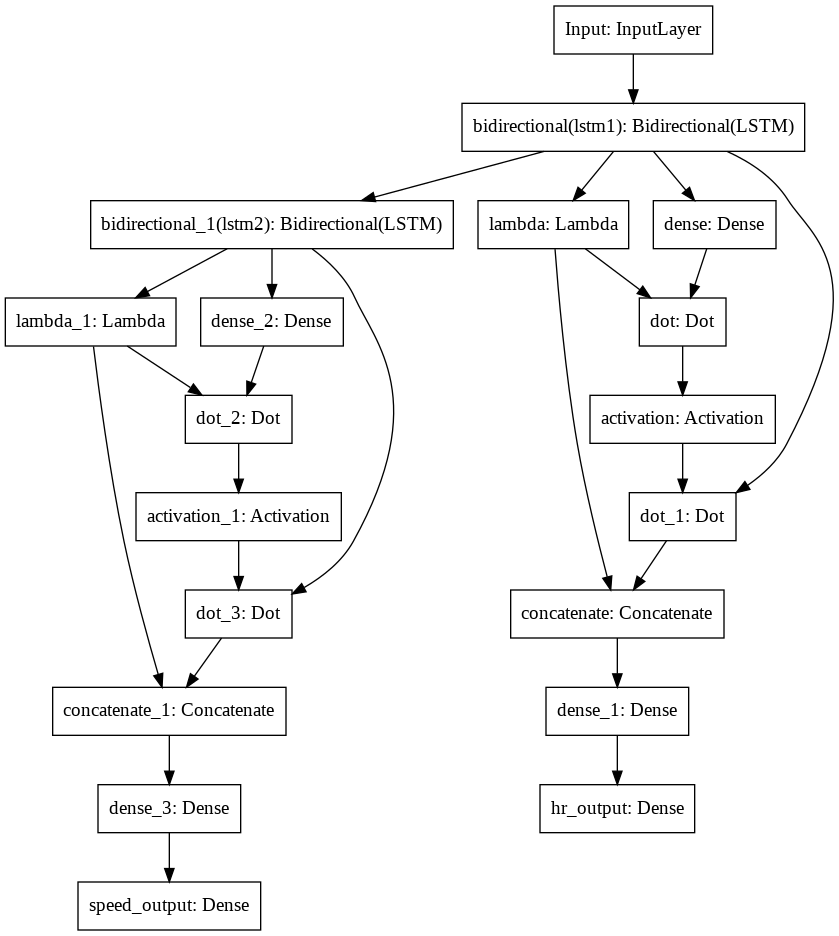

In [44]:
model = two_layer_BiLSTM_Attention()
plot_model(model)

In [45]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 499, 35)]    0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 499, 128)     51200       Input[0][0]                      
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 499, 128)     98816       bidirectional[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 499, 128)     16384       bidirectional_1[0][0]            
_______________________________________________________________________________________

## Train Model

In [46]:
batch_size = 256
epochs = 50 
history = model.fit(batch_generator(train_df,batch_size),
            steps_per_epoch = len(train_df)/batch_size,
            validation_data = batch_generator(test_df,batch_size),
            validation_steps=1,epochs=epochs)

Epoch 1/10
197/196 [==============================] - 350s 2s/step - loss: 0.1918 - speed_output_loss: 0.0780 - hr_output_loss: 0.1138 - val_loss: 0.1268 - val_speed_output_loss: 0.0494 - val_hr_output_loss: 0.0773
Epoch 2/10
197/196 [==============================] - 352s 2s/step - loss: 0.1179 - speed_output_loss: 0.0460 - hr_output_loss: 0.0718 - val_loss: 0.1131 - val_speed_output_loss: 0.0448 - val_hr_output_loss: 0.0684
Epoch 3/10
197/196 [==============================] - 350s 2s/step - loss: 0.1109 - speed_output_loss: 0.0434 - hr_output_loss: 0.0676 - val_loss: 0.1172 - val_speed_output_loss: 0.0482 - val_hr_output_loss: 0.0690
Epoch 4/10
197/196 [==============================] - 347s 2s/step - loss: 0.1083 - speed_output_loss: 0.0423 - hr_output_loss: 0.0661 - val_loss: 0.1099 - val_speed_output_loss: 0.0430 - val_hr_output_loss: 0.0668
Epoch 5/10
197/196 [==============================] - 350s 2s/step - loss: 0.1067 - speed_output_loss: 0.0416 - hr_output_loss: 0.0651 - val

## Evaluate Model

In [ ]:
batch_size = 256
model.evaluate_generator(generator=batch_generator(train_df,batch_size),steps=len(train_df)/batch_size,verbose=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
197/196 [==============================] - 361s 2s/step - loss: 0.0787 - speed_output_loss: 0.0288 - hr_output_loss: 0.0499


[0.07873091846704483, 0.02883896604180336, 0.049891941249370575]

In [ ]:
batch_size = 256
model.evaluate_generator(generator=batch_generator(test_df,batch_size),steps=len(test_df)/batch_size,verbose=1)

50/49 [==============================] - 89s 2s/step - loss: 0.0796 - speed_output_loss: 0.0290 - hr_output_loss: 0.0506


[0.07959416508674622, 0.029024815186858177, 0.05056934058666229]

In [ ]:
# inverse_scaler
def inverse_scaler(feature,value):
  return  scaler_dic[feature].inverse_transform([[value]])

In [ ]:
print(inverse_scaler('heart_rate',0.0506))
print(inverse_scaler('speed',0.0290))

[[14.4]]
[[3.49994326]]


## Save Model

In [ ]:
#save model
dir = '/content/gdrive/My Drive/endomondoHR/Data/model/Final Model'
path = os.path.join(dir,'[1210]bilstm.h5')
model.save(path)
print(path)

/content/gdrive/My Drive/endomondoHR/Data/model/Final Model/[1115]single_user.h5


##Load Model


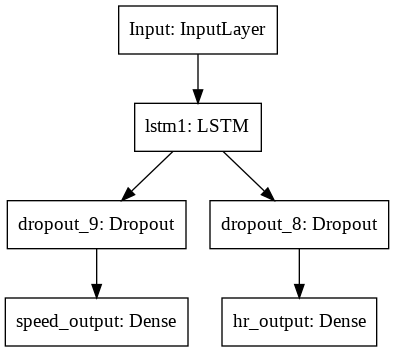

In [ ]:
# Load trained model：
model = load_model('/content/gdrive/My Drive/endomondoHR/Data/model/Final Model/[1210]bilstm.h5')
plot_model(model)